# Multilayer networks

In the last subject, we learned about neural networks and saw the basic TensorFlow tools to build them. So far, we created networks with a single layer of neurons which are equivalent to linear, logistic or softmax regressions. In this unit, we will see that we can build more powerful models by simply adding layers of neurons with nonlinear activation functions. In the second part of this unit, we will implement a 2-layer neural network using TensorFlow to classify images from the MNIST data set.

The idea behind multilayer networks is to add layers of neurons between the input and the output layer. Here is an illustration of a simple multilayer network with three input neurons, two hidden layers with respectively two and three hidden units, and an output layer with two neurons.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    ### force CPU on tensorflow

In [2]:
from IPython.display import Image
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2752/multilayer.svg')

The goal of these hidden layers is to convert the input into a set of useful features which are then combined in the output layer to compute predictions. In other words, multilayer networks do not only learn to combine features but also learn these features by themselves. The idea is that each intermediate layer combines its inputs into a set of higher-level features that are then used in the next layer and so on. To achieve this, networks use **activation functions** which are simply functions that each neuron applies to its output.

### Activation functions

We saw in the last subject that each neuron computes its output by multiplying the signal sent by its input neurons with its synaptic weights and by adding the neuron bias. In the multilayer neural network case, we can express the output $ x_{j}^{\left(l\right)}$ of the j-th neuron of layer 
l
 with the following expression.
 
$$
x_{j}^{\left(l\right)}=\sum_{i}w_{i,j}^{\left(l\right)}x_{i}^{\left(l-1\right)}+b_{j}^{\left(l\right)}
$$

In this formula, we multiply the signal from each neuron from the previous layer 
x
(
l
−
1
)
i
 with the corresponding synaptic weight 
w
(
l
)
i
,
j
 and add the neuron bias 
b
(
l
)
j
. In multilayer networks, we apply an activation function 
ϕ
 to the output of each neuron.
 
 $$ x_{j}^{\left(l\right)}=\phi\left(\sum_{i}w_{i,j}^{\left(l\right)}x_{i}^{\left(l-1\right)}+b_{j}^{\left(l\right)}\right)$$
 
Activation functions and hidden layers are really at the heart of neural networks. In fact, it's possible to show that a network with a single hidden layer can approximate any continuous function. This is called **the universal approximation theorem**. If you want to learn more about it, we highly recommend reading chapter 4 of the Neural Networks and Deep Learning (NNDL) book which gives a visual explanation of the theorem. http://neuralnetworksanddeeplearning.com/chap4.html

### Sigmoid and ReLU activation

There are many possible activation functions. For instance, we can use the sigmoid function that we saw in the unit about logistic regressions.

$$ f\left(x\right)=\frac{1}{1+e^{-x}}$$

Here is a plot of the function for an input between -6 and +6.

In [3]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2751/sigmoid.svg')

**One issue with the sigmoid function is that its derivative is close to zero (the curve is flat) when the input is very large or very small. Hence, the gradient update will be very small when updating the weights with gradient descent and the learning process becomes slow**. This is called the **vanishing gradient problem.**

Another popular activation function is the **Rectified Linear Unit (ReLU).**
$$ f\left(x\right)=\max\left(0,x\right)$$
The function is zero when 
x
 is negative and equal to 
x
 when it's positive.

In [4]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2750/relu.svg')

One of the advantages of the ReLU activation function is that it's easy to implement and it seems to accelerate the learning process compared to the sigmoid one. You can take a look at this page if you want to learn more about activation functions. http://cs231n.github.io/neural-networks-1/#actfun

### Backpropagation

In the last course, we learned about the **gradient descent method** which updates the model parameters by computing the partial derivate of the loss function with respect to each parameter. In neural networks, **we use the same idea to update the weights and biases** of each neuron in our network. In practice, **deep networks have a lot of parameters and it would be very inefficient to compute the partial derivative of each weight individually.** **However, there is a technique called backpropagation** which can solve this issue. To avoid doing redundant computations, the backpropagation algorithm computes the error at the ouput neurons and propagates this information back through the network to compute the partial derivates layer after layer.

In [5]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2749/backward-prop.svg')

Backpropagation is usually performed internally by the deep learning framework. For instance, when using **the GradientDescentOptimizer object, TensorFlow will automatically compute the gradients in an efficient way using the backpropagation algorithm**. If you want to learn more about the mathematics behind backpropagation, you can take a look at chapter 2 of the NNDL book. http://neuralnetworksanddeeplearning.com/chap2.html

### Weights initialization

So far, we initialized the synaptic weights of each neuron to zero. This sounds reasonable if we standardized the data since we expect some weights to be positive, some to be negative, but in average, centered around zero. **In multilayer networks, initializing the weights to a constant value (e.g., zero or one) is a bad idea because it makes all hidden units of a layer compute the exact same output**. In that case, gradient descent will compute the same gradient updates and we will end up with copies of the hidden units with the same weight values.

One solution is to use a normal distribution to **sample small random numbers.** That way, each hidden neuron will start with different weights and will occupy a different role in our network. In practice, we often use the truncated normal distribution which drops values whose magnitude is more than 2 standard deviations away from the mean. For instance, here is the truncated normal distribution with a standard deviation of 0.01

In [6]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2748/truncated-normal.svg')

Ideally, we want to calibrate this standard deviation such that each neuron computes an output in a reasonable range for its activation function. When there are no activation function (e.g., in the output layer), it's recommended to set the standard deviation to the inverse of the square root of the number of input neurons 
n
. $$ \text{std}=\frac{1}{\sqrt{n}} $$

For layers with ReLU activations, the formula is a bit different.

$$ \text{std}=\sqrt{\frac{2}{n}} $$

We won't go into the derivation of these two formulas, but you can take a look at this page if you want to learn more about it. http://cs231n.github.io/neural-networks-2/#init


### TensorFlow implementation
---------

Now that we know the basic idea behind multilayer neural networks, let's go through a concrete example. In this second part, we will implement a 2-layer neural network with 16 hidden units in the hidden layer to classify images from the MNIST data set.

Let's start by creating the TensorFlow graph.

In [7]:
import tensorflow as tf

# Create a new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    W1 = tf.Variable(initial_value=tf.truncated_normal(
        shape=[784, 16], # Shape
        stddev=(2/784)**0.5, # Calibrating variance
        seed=0
    ))
    b1 = tf.Variable(initial_value=tf.zeros(shape=[16]))

    # Output layer
    W2 = tf.Variable(initial_value=tf.truncated_normal(
        shape=[16, 10], # Shape
        stddev=1/16**0.5, # Calibrating variance
        seed=0
    ))
    b2 = tf.Variable(initial_value=tf.zeros(shape=[10]))

    # Compute logits
    hidden = tf.nn.relu( # ReLU
        tf.add(tf.matmul(X, W1), b1))
    logits = tf.add(tf.matmul(hidden, W2), b2)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In this code, we create a matrix of weights and vector of biases for each layer. The input layer has 784 input neurons which correspond to the pixels in the 28 by 28 grayscale images from the MNIST database. This input layer is connected to an intermediate hidden layer with 16 units. Hence, the shape of the weight matrix of the hidden layer is 
(
784
,
16
)
 and it bias vector has 16 elements. We create a second weight matrix to connect the hidden and output layers. Since there are ten output units, its shape is 
(
16
,
10
)
.

Finally, we compute the output of the hidden layer by multiplying the input and the weight matrices, add the bias and apply the ReLU activation function with the relu() function. Then, we compute the output of the network using this hidden tensor.

Note that we initialize the weights using the truncated_normal() function and calibrate the standard deviation using the formulas from above. For the output layer, we use the first formula since it has no activation function, but use the second one for the hidden layer since it uses the ReLU activation.

It's not really convenient to work with the code from above because the number of hidden units is repeated at different places.

- The shape of W1
- The shape of b1
- The shape of W2
- The standard deviation of W2


**To solve this issue, we can use the dense() function from the layers module and the TensorFlow initializers.**

In [8]:
# Redefine the graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    hidden = tf.layers.dense(
        X, 16, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )

    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )

This time, we only have to write once the number of units in each layer which is more convenient if we want to experiment with it, e.g., try different sizes for the hidden layer. We define each fully-connected layer with the dense() function which takes the input data, the number of output units, the activation function and the weights and bias initializers. We use the zeros_initializer() to initialize the biases to zero and the variance_scaling_initializer() to initialize the weights using the formulas from above. Note that we assign names to each layer. These names will make it easier to access the different layers and their elements.

The dense() function creates the weights and biases variables with the appropriate shape and initialize them using the specified initializers. **We can inspect the variables from the graph using the trainable_variables() function.**

In [9]:
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)


<tf.Variable 'hidden/kernel:0' shape=(784, 16) dtype=float32_ref>
<tf.Variable 'hidden/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'output/kernel:0' shape=(16, 10) dtype=float32_ref>
<tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>


Note that it's possible to retrieve these variables using the variable_scope() and the get_variable() function.

In [10]:
with graph.as_default():
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

### Loss function and training operation

Now that the different layers of our neural network are specified, we can move on and define the loss function and training operations using the code from the previous units.


In [11]:
with graph.as_default():
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

### Train network

Let's train the network. First, we have to load the MNIST images, split them into train and validation sets and standardize the features using a StandardScaler transformer from Scikit-learn. The network is a bit larger this time since it has an additional hidden layer with 16 units. For this reason, we will train it using a slightly larger data set with 20 thousand images. You can download it from the resource section.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load data
with np.load('mnist-20k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32),
    mnist['labels'],
    test_size=500, random_state=0)

# Rescale train and validation data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

In [13]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'labels': array([5, 0, 4, ..., 1, 4, 2])}

This time, we will train the network using the entire data set several times. In the machine learning jargon, **one pass of training through the entire training set is called an epoch**. In practice, we usually shuffle the data before each epoch to get better results. Let's modify our get_batches() function from the previous unit.

In [14]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In this code, we create and shuffle a list of indexes and use it to iterate through our training data by small random batches.

Finally, let's train our network during 50 epochs.

In [15]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - valid: 0.796 train: 0.631 (mean)
Epoch 2 - valid: 0.888 train: 0.849 (mean)
Epoch 3 - valid: 0.900 train: 0.881 (mean)
Epoch 4 - valid: 0.916 train: 0.897 (mean)
Epoch 5 - valid: 0.918 train: 0.906 (mean)
Epoch 6 - valid: 0.922 train: 0.914 (mean)
Epoch 7 - valid: 0.920 train: 0.919 (mean)
Epoch 8 - valid: 0.922 train: 0.923 (mean)
Epoch 9 - valid: 0.934 train: 0.926 (mean)
Epoch 10 - valid: 0.932 train: 0.929 (mean)
Epoch 11 - valid: 0.930 train: 0.932 (mean)
Epoch 12 - valid: 0.938 train: 0.934 (mean)
Epoch 13 - valid: 0.940 train: 0.936 (mean)
Epoch 14 - valid: 0.942 train: 0.939 (mean)
Epoch 15 - valid: 0.944 train: 0.941 (mean)
Epoch 16 - valid: 0.942 train: 0.943 (mean)
Epoch 17 - valid: 0.944 train: 0.944 (mean)
Epoch 18 - valid: 0.944 train: 0.947 (mean)
Epoch 19 - valid: 0.942 train: 0.947 (mean)
Epoch 20 - valid: 0.944 train: 0.949 (mean)
Epoch 21 - valid: 0.946 train: 0.950 (mean)
Epoch 22 - valid: 0.948 train: 0.951 (mean)
Epoch 23 - valid: 0.946 train: 0.952 (mea

In this code, we save the accuracy on each batch of training data and compare its mean to the accuracy on the validation set. This is a way to monitor overfitting and decide when to stop the network, i.e., the number of epochs to run. Finally, we save the trained weights with eval().

Let's plot the validation accuracy after each epoch.

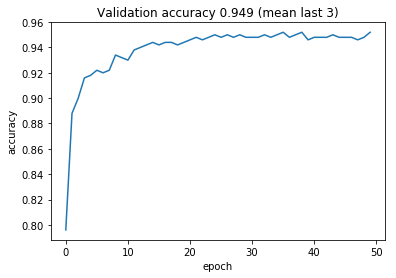

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

This time, we get an accuracy of 95% which is a lot better than our softmax network from the last subject with 85%.

### Visualize weights

Finally, let's visualize the weights of the 16 hidden units using the code from the previous unit.


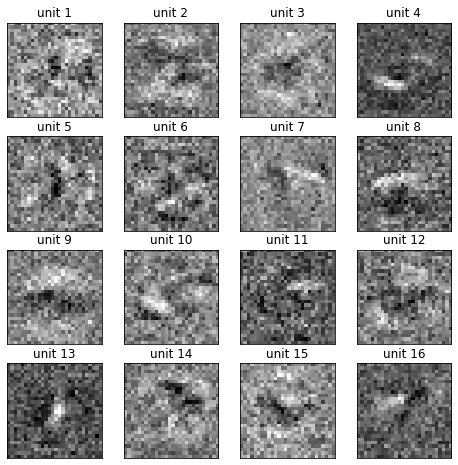

In [17]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1))
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

As we can see, the hidden units detect specific shapes that are then combined in the output layer.

Let's see how by printing the weights matrix from the output layer.

In [18]:
import pandas as pd

# Output layer weights
pd.DataFrame(
    weights_output,
    index=['unit {}'.format(i+1) for i in range(16)],
    columns=['digit {}'.format(i) for i in range(10)],
)

,digit 0,digit 1,digit 2,digit 3,digit 4,digit 5,digit 6,digit 7,digit 8,digit 9
unit 1,-0.151154,0.284383,0.172240,0.446757,-0.713837,-0.183502,0.480000,0.116505,0.348728,-0.560343
unit 2,-0.533486,-0.624569,0.205263,-0.056235,-0.039790,-0.083849,-0.584665,1.024174,-0.344761,-0.045943
unit 3,0.073382,0.799233,-0.129844,-0.049881,0.641498,0.478644,-0.723321,-0.508682,-0.525338,0.611302
unit 4,-0.272541,0.319896,-0.086140,0.961810,0.315077,1.009274,-0.286930,-0.434322,-0.607752,0.439435
unit 5,-0.391177,0.912025,-0.416022,-0.429280,-0.021465,-0.192731,0.417162,0.325653,0.743411,0.002196
unit 6,-0.133980,-0.484260,0.186193,0.347374,-0.065938,-0.113913,-0.330738,-0.504146,0.871023,-0.370285
unit 7,-0.162729,-0.269187,-0.383834,-0.803973,-0.550541,0.650970,0.613403,-0.133621,0.655968,-0.386253
unit 8,-0.093046,0.015065,1.257029,-0.055928,-0.113261,0.205466,0.349967,-0.395460,-0.334838,-0.443182
unit 9,0.058085,-0.596844,0.651317,-0.048199,0.510600,-0.239703,0.634887,-0.066740,-0.398665,-0.893872
unit 10,-0.225225,-0.145421,-0.133121,0.659437,-0.405561,0.560544,-0.709347,-0.281558,0.334449,0.198543


This weights matrix tells us how each output neuron computes its activation. For instance, we can see that the 4th hidden unit is used by the output neurons for digits 3, 5 and 9 which makes sense since they all have the rounded curve at the bottom of the image learned by this hidden unit.

### Summary

In this unit, we saw the idea behind multilayer networks such as hidden layers and activation functions, and saw how to implement one using TensorFlow. In practice, it's common to build 2- or 3-layer networks with this architecture of dense or fully-connected layers neurons. **These networks are very powerful but can easily overfit the training data**. In the next unit, we will learn about **dropout** which is a very efficient way to reduce overfitting in neural networks.

### Q&A


**Why simple activation functions as ReLU improve network learning?
Could you please explain why such simple activation function a ReLU is useful for the network training? When do we need to apply them and how to choose one?**

> The activation functions in the hidden layers, such as Sigmoid and ReLU, introduce non-linearity in the model. Hence, they help to solve non-linear problems and extract non-linear features (e.g. classification with non-linear separation between the classes). If we just concatenate the hidden layers in a neural network without activation functions, the overall model will be mathematically equivalent to a single-layer linear model. This is because 
w
l
(
w
l
−
1
x
+
b
l
−
1
)
+
b
l
 will be equivalent to a single layer linear operation.

> Indeed, it is surprising that a simple function like Sigmoid or ReLU is enough. There is some theory behind this in case you are interested. In fact, any activation function that looks like a smooth step-function is useful to introduce non-linearity and learn a complicated linear model. This is what is called the Universal Approximation Theorem in deep learning. A simple visualization of this theorem is available here.

> You should always use activation functions for hidden layers in the neural network, otherwise your network will be the same as a simple linear model (linear regression or logistic regression). Whether to choose Sigmoid, ReLU, Tanh (tangent hyperbolic), or any other function for the activation of the hidden layers depends on the data and specific setup. The type of the activation function is one of the hyperparameters that you can tune. A common choice based on previous experimentation is the ReLU function. It was proven that ReLU is numerically more stable than Sigmoid with very deep neural networks. This is because ReLU suffers less from the Vanishing Gradient Problem, as it is saturated from the left-side only. You can stick with ReLU for the hidden layers. However, note that the activation function at the output layer depends on the task and you don't have much freedom there. If the task is a binary classification, then the output activation is Sigmoid. If it is a multi-class classification, the output activation is Softmax.

> PS: The theoretical explanation of the Universal Approximation Theorem and Vanishing Gradient Problem is beyond the scope of this course. This is just to give you exposure if you are interested.



**The exercise suggests that we should test different architectures and hyper parameters. However, when I try to create a placeholder for the number of neurones in the hidden layer, and pass it as a such to the tf.layers.dense(), the same way we do with X, I get an error.
Is there a more efficient way to look for the optimal number of hidden neurones rather than re-writing the entire graph, and changing the names of variables?**

> That is correct, with the current TensorFlow implementation you can not pass a placeholder to the units in tf.layers.dense() as we did for the learning rate. This is because it alters the whole graph. For that, you need to create a graph each time in the grid search loop. Here is a pseudo-code:

for parameter in grid: # ----> loop over the hyperparameters

    # Create new graph
    tf.reset_default_graph()
    graph = tf.Graph()
    with graph.as_default():
       ...... # ----> Define all layers
       hidden = tf.layers.dense(X, units=parameter) # ----> set the hyerparameter
       ......

    # Start a session
    with tf.Session(graph=graph) as sess:
       ....
> You will see later with the high-level Keras API, such tuning becomes easier because you will not need to define a graph and then run a session separately.


### Exercise 4-8-1 and 4-8-2